# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively dense (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively sparse (represented as a bag-of-words). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
import sklearn

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# import pandas
import pandas as pd
import re
import string
import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Part 1:

For each of the first 5 training examples, print the text of the message along with the label.

In [24]:
def P1(num_examples=5):
    ### STUDENT START ###
    
    for i in range(num_examples): #for as many examples as we specified
        print("\nText",i+1) #print the number of the text
        print('category:',categories[train_labels[i]]) #print the category to which the message belongs to
        print('\n',train_data[i]) #print the actual message
        print('---------------------------------------------------------------')
    ### STUDENT END ###
P1(5)


Text 1
category: talk.religion.misc

 Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
---------------------------------------------------------------

Text 2
category: sci.space

 

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes 

### Part 2:

Transform the training data into a matrix of **word** unigram feature vectors.  What is the size of the vocabulary? What is the average number of non-zero features per example?  What is the fraction of the non-zero entries in the matrix?  What are the 0th and last feature strings (in alphabetical order)?<br/>
_Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._

Now transform the training data into a matrix of **word** unigram feature vectors using your own vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. What is the average number of non-zero features per example?<br/>
_Use `CountVectorization(vocabulary=...)` and its `.transform` method._

Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._

Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(min_df=...)` and its `.fit_transform` method._

Now again transform the training data into a matrix of **word** unigram feature vectors. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?<br/>
_Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html.  

In [247]:
def P2():
    ### STUDENT START ###
    
    #Word unigram
    print("Word unigram")
    vocabulary = CountVectorizer() #create CountVectorizer instance
    voctrain = vocabulary.fit_transform(train_data) #fit training data to it
    print("Size:",voctrain.shape[1]) #get length of CV matrix to find size
    occurences = [i.nnz for i in voctrain] #get number of non-zero features for every message in data
    print("Average number of non-zero features per example:", sum(occurences)/len(occurences)) #sum the number of non-zero features and divide by number of messages to get average
    print("Fraction of non-zero entries in matrix:",sum(occurences)/voctrain.shape[1]) #divide total number of non-zero occurences by total number of words in our vocabulary
    print("First feature string:",vocabulary.get_feature_names()[0], "\nLast feature string:", vocabulary.get_feature_names()[-1]) #get_feature_names gives us an alphabetically sorted list of words so we get the first and last words
    
    #Word unigram with vocabulary
    print("\nWord unigram with vocabulary")
    vocabulary2 = CountVectorizer(vocabulary=["atheism", "graphics", "space", "religion"]) #create CountVectorizer object with our specified vocabulary
    voctrain2 = vocabulary2.transform(train_data) #fit training data to it
    print("Size:",voctrain2.shape[1]) #get length of CV matrix to find size
    occurences2 = [i.nnz for i in voctrain2] #get number of non-zero features for every message in data
    print("Average number of non-zero features per example:", sum(occurences2)/len(occurences2)) #as above
    
    #Character bigram and trigram
    print("\nCharacter bigrams and trigrams")
    char = CountVectorizer(analyzer='char', ngram_range=(2,3)) #create CountVectorizer object, analyzer and ngram_range are set to find combinations of 2 and 3 characters
    char_fit = char.fit_transform(train_data) #fit training data to it
    print("Size:",char_fit.shape[1]) #get length of vocabulary
    
    #Word unigram, pruned
    print("\nPruned word unigram")
    vocab_p = CountVectorizer(min_df=10) #create CountVectorizer object with min_df set to not include words that show up in less than 10 documents
    vocab_pruned = vocab_p.fit_transform(train_data) #fit training data to it
    print("Size:", vocab_pruned.shape[1]) #get length of vocabulary
    
    #Word unigram
    vocab_t = CountVectorizer() #create CountVectorizer instance
    vocab_train = vocab_t.fit_transform(train_data) #fit training data to it
    vocab_d = CountVectorizer() #create CountVectorizer instance
    vocab_dev = vocab_d.fit_transform(dev_data) #fit dev data to it
    
    dev_list = vocab_d.get_feature_names() #get a sorted string list of the dev set's vocabulary
    train_list = vocab_t.get_feature_names() #get a sorted string list of the training set's vocabulary
    k=0 #counter
    for word in dev_list: # for every word in the dev set vocabulary
        if word not in train_list: #if that word is not in the training set vocabulary, increase counter by 1
            k+=1
    print("\nFraction of words in development vocabulary missing from training vocabulary:",(k/vocab_dev.shape[1])) #divide number of dev set words not in training set by total number of dev set words
    ### STUDENT END ###

P2()

Word unigram
Size: 26879
Average number of non-zero features per example: 96.70599803343165
Fraction of non-zero entries in matrix: 7.317980579634659
First feature string: 00 
Last feature string: zyxel

Word unigram with vocabulary
Size: 4
Average number of non-zero features per example: 0.26843657817109146

Character bigrams and trigrams
Size: 35478

Pruned word unigram
Size: 3064

Fraction of words in development vocabulary missing from training vocabulary: 0.24787640034470024


### Part 3:

Transform the training and development data to matrices of word unigram feature vectors.

1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score.
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.

* Why doesn't k-Nearest Neighbors work well for this problem?
* Why doesn't Logistic Regression work as well as Naive Bayes does?
* What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

k-Nearest Neighbors Models
--------------------------

k-Nearest Neighbor Model with k = 1
F1 score: 0.3805030018531525

k-Nearest Neighbor Model with k = 3
F1 score: 0.4084150225437623

k-Nearest Neighbor Model with k = 5
F1 score: 0.4287607236218357

k-Nearest Neighbor Model with k = 7
F1 score: 0.45047910006117586

k-Nearest Neighbor Model with k = 9
F1 score: 0.4365666176198027

k-Nearest Neighbor Model with k = 11
F1 score: 0.4266108018696209

k-Nearest Neighbor Model with k = 13
F1 score: 0.42404338833763805

k-Nearest Neighbor Model with k = 15
F1 score: 0.4326339805547054

k-Nearest Neighbor Model with k = 17
F1 score: 0.4485853212909305

k-Nearest Neighbor Model with k = 19
F1 score: 0.4365794782510113

k-Nearest Neighbor Model with k = 21
F1 score: 0.42609394906353587

k-Nearest Neighbor Model with k = 23
F1 score: 0.40811738399495695

k-Nearest Neighbor Model with k = 25
F1 score: 0.41610581482270387

k-Nearest Neighbor Model with k = 27
F1 score: 0.424466893547113

k-Neares

Squared Weights Sum for alt.atheism : 148.7353345849192
Squared Weights Sum for talk.religion.misc : 117.4038193375142
Squared Weights Sum for comp.graphics : 141.45939666426773
Squared Weights Sum for sci.space : 129.62864667312593
F1 score: 0.694281290097654

Logistic Regression Model with C = 0.8948421052631579
Squared Weights Sum for alt.atheism : 155.17991333760685
Squared Weights Sum for talk.religion.misc : 122.10160603459629
Squared Weights Sum for comp.graphics : 147.03503561698363
Squared Weights Sum for sci.space : 135.13921565350827
F1 score: 0.694281290097654

Logistic Regression Model with C = 0.9474210526315789
Squared Weights Sum for alt.atheism : 161.08379275064948
Squared Weights Sum for talk.religion.misc : 126.57717541095812
Squared Weights Sum for comp.graphics : 152.61626566339558
Squared Weights Sum for sci.space : 140.49045249715445
F1 score: 0.694281290097654

Logistic Regression Model with C = 1.0
Squared Weights Sum for alt.atheism : 166.99766570190866
Square

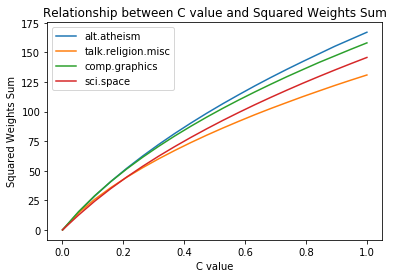

In [171]:
def P3():
## STUDENT START ###
    vocab_t = CountVectorizer() #create CountVectorizer instance
    vocab_train = vocab_t.fit_transform(train_data) #fit training data to it
    vocab_dev = vocab_t.transform(dev_data) #transform dev data

    k_values = [(2*i)+1 for i in range(20)] #creates list of different k values to be tested on knn model
    alphas = np.linspace(0.1,10,20) #creates list of different alpha values to be tested on nb model
    c_vals = np.linspace(0.001,1, 20) #creates list of different c values to be tested on logistic regression model
    scores_knn = [] #create empty lists to put f1 scores in
    scores_nb = []
    scores_lr = []
    weights = [[],[],[],[]] #create empty list with 4 sublists corresponding to the 4 thematic categories

    def sq_weights(weights): #function that takes weights from a weights list and returns their square sum
        s = 0
        for i in weights: #for every weight in the weights list
            s += i**2 #square the weight and add it to the total sum
        return s #return the sum of squares

    print("k-Nearest Neighbors Models")
    print("--------------------------")
    for k in k_values: #for k in list of k values
        print("\nk-Nearest Neighbor Model with k =", k) 
        knn_model = KNeighborsClassifier(n_neighbors=k) #create knn model with k number of neighbors
        fitted_data = knn_model.fit(vocab_train, train_labels) #fit training data to it
        predicted_data = knn_model.predict(vocab_dev) #predict on transformed dev data
        f1 = metrics.f1_score(dev_labels, predicted_data, average="weighted") #get f1 score of prediction
        scores_knn.append(f1) #append f1 score to list of scores
        print("F1 score:",f1)
    print("\nBest k-value:", k_values[scores_knn.index(max(scores_knn))]) #returns the value in k values list for which we got the highest f1 score


    print("\nNaive Bayes Models")
    print("--------------------------")
    for a in alphas: #for a in list of alphas
        print("\nNaive Bayes Model with alpha =", a)
        nbmodel = MultinomialNB(alpha=a)  #create nb model with alpha parameter equal to a
        fitted_data = nbmodel.fit(vocab_train, train_labels) #fit training data to it
        predicted_data = nbmodel.predict(vocab_dev) #predict on transformed dev data
        f1 = metrics.f1_score(dev_labels, predicted_data, average="weighted") #get f1 score of prediction
        scores_nb.append(f1) #append f1 score to list of scores
        print("F1 score:",f1)
    print("\nBest alpha:", alphas[scores_nb.index(max(scores_nb))]) #returns the alpha value in our list for which we got the highest f1 score


    print("\nLogistic Regression Models")
    print("--------------------------")
    for c in c_vals: #for c in list of c_values
        print("\nLogistic Regression Model with C =", c)
        lreg_model = LogisticRegression(C=c, solver="liblinear", multi_class="auto") #create logistic regression model with C parameter equal to c
        fitted_data = lreg_model.fit(vocab_train, train_labels) #fit training data to it
        predicted_data = lreg_model.predict(vocab_dev) #predict on transformed dev data
        for i in range(len(categories)):  #for each of the 4 thematic categories
            print("Squared Weights Sum for",categories[i],":",sq_weights(lreg_model.coef_[i])) #print the sum of squared weights for this category

            weights[i].append(sq_weights(lreg_model.coef_[i])) #append the sum of squared weights to weights list, in the corresponding sublist
        f1 = metrics.f1_score(dev_labels, predicted_data, average="weighted") #get f1 score of prediction
        scores_lr.append(f1) #append f1 score to list of scores
        print("F1 score:",f1)
    print("\nBest C value:", c_vals[scores_lr.index(max(scores_lr))]) #returns the c value in our list for which f1 is maximized

    plt.plot(c_vals, weights[0], label=categories[0]) #plot line of sum of squared weights by c value for category 1
    plt.plot(c_vals, weights[1], label=categories[1]) #plot line of sum of squared weights by c value for category 2
    plt.plot(c_vals, weights[2], label=categories[2]) #plot line of sum of squared weights by c value for category 3
    plt.plot(c_vals, weights[3], label=categories[3]) #plot line of sum of squared weights by c value for category 4
    plt.ylabel("Squared Weights Sum")
    plt.xlabel("C value")
    plt.title("Relationship between C value and Squared Weights Sum")
    plt.legend() #show legend
    plt.show()

    ## STUDENT END ###

P3()

ANSWER: k-Nearest Neighbors does not work well with this problem because a single word can appear in different contexts. For instance, the word "god" can be found in a context such as "the god I believe in is Zeus" but also in the sentences "I don't believe in god" or "Oh god this is the best GPU out there".

Logistic regression does not work as well as Naive Bayes does because it works by minimizing a cost function that takes into account all of the word features together. On the other hand, Naive Bayes uses separate weights for each of the words, thereby being less biased.

Lastly, regarding the realtionship between sum of squared weights and C value in logistic regression, as C value increases, so does the sum of squared weights.

### Part 4:

Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.  For each topic, find the 5 features with the largest weights (that's 20 features in total).  Show a 20 row (features) x 4 column (topics) table of the weights.

Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 

In [252]:
def P4():
    ### STUDENT START ###
    bigram = CountVectorizer(analyzer='word', ngram_range=(2,2)) #create CountVectorizer object that takes into account word bigrams
    bigram_train = bigram.fit_transform(train_data) #fit & transform training data
    bigram_dev = bigram.transform(dev_data) #transpose dev data
    
    lreg_model = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto") #create logistic regression model
    fitted_data = lreg_model.fit(bigram_train, train_labels) #fit training data
    predicted_data = lreg_model.predict(bigram_dev) #predict on dev data
    
    def five_top(weights): #function that takes in feature weights matrix and returns the top 5 bigrams with largest weights for each category
        five_top = [] 
        for topic in weights: #for each topic included in our weights matrix
            inds = np.argsort(topic)[0:5] #sort weights by index value and get indices for 5 largest weights
            words = [bigram.get_feature_names()[i] for i in inds] #get bigrams for the indices in the inds list
            five_top.append(words) #append words to list
        return five_top #return list
    
    top = five_top(lreg_model.coef_) #get top bigrams given our model's weight coefficients as input
    table = {categories[c]: top[c] for c in range(len(categories))} #create a dictionary with topics as columns and bigrams as rows
    df = pd.DataFrame(table) 
    print(df) #print dictionary as DataFrame
    ### STUDENT END ###

P4()

     alt.atheism talk.religion.misc comp.graphics    sci.space
0    looking for        cheers kent   cheers kent  looking for
1        want to           that the     the bible  does anyone
2        for the          the space   looking for       on the
3     in advance           the moon       you are   in advance
4  interested in          the bible       in this      able to


ANSWER: There are some surprising bigrams that show up in more than one categories such as "cheers kent", that shows up in both the religion and computer graphics topics, as well as the bigram "looking for" which shows up in atheism and space.

### Part 5:

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

Produce a Logistic Regression model (with no preprocessing of text).  Evaluate and show its f1 score and size of the dictionary.

Produce an improved Logistic Regression model by preprocessing the text.  Evaluate and show its f1 score and size of the vocabulary.  Try for an improvement in f1 score of at least 0.02.

How much did the improved model reduce the vocabulary size?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.

In [257]:
def better_preprocessor(s): #
    ## STUDENT START ###
    
    words = s.split() #take message and split it into words
    new_words = [] #create new list that will become our new sentence
    
    #define a list of stop_words which have little to zero informational value
    stop_words = ['i','me','my','myself','we','our','ours','ourselves','you','your','yours','yourself','yourselves','he','him','his','himself','she','her','hers','herself','it','its','itself','they','them','their','theirs','themselves','what','which','who','whom','this','that','these','those','am','is','are','was','were','be','been','being','have','has','had','having','do','does','did','doing','a','an','the','and','but','if','or','because','as','until','while','of','at','by','for','with','about','against','between','into','through','during','before','after','above','below','to','from','up','down','in','out','on','off','over','under','again','further','then','once','here','there','when','where','why','how','all','any','both','each','few','more','most','other','some','such','no','nor','not','only','own','same','so','than','too','very','s','t','can','will','just','don','should','now']
    
    for word in words: #for every word in our message
        
        word = re.sub('[^A-Za-z0-9]+', '', word) #remove all symbols that are not numbers or letters
        word = re.sub("[0-9]+", "x", word) #replace all number sequences with x
        
        if word in stop_words: #if the word is included in our stop words, replace it with an asterisk and append it to our new list
            new_words.append("*")
        elif len(word)>6: #if a word has more than 6 characters, keep only the first 6 characters and append
            new_words.append(word[0:6])
        else: #append to list
            new_words.append(word)
            
            
    s = " ".join([word for word in new_words]) #join all words in new_words list into a new message
    return s.lower() #return new message in lower case
    ## STUDENT END ###
    
def empty_preprocessor(s): #empty preprocessor that just returns the string
    
    return s

def P5():
    ## STUDENT START ###
    vocab = CountVectorizer(preprocessor=empty_preprocessor) #create CountVectorizer object with empty preprocessor
    vocab_train = vocab.fit_transform(train_data) #fit and transform training data
    vocab_dev = vocab.transform(dev_data) #transform dev data
    
    lreg_model = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto") #create logistic regression model with C=0.5
    fitted_data = lreg_model.fit(vocab_train, train_labels) #fit training data
    predicted_labels = lreg_model.predict(vocab_dev) #predict on dev data
    
    f1 = metrics.f1_score(dev_labels, predicted_labels, average='weighted') #get f1 score and print it
    
    print("f1 score for empty preprocessor",f1)
    print("size of training vocabulary:",vocab_train.size) #print size of vocabulary
    print()
    
    vocab_pre = CountVectorizer(preprocessor=better_preprocessor) #create CountVectorizer object with better preprocessor
    vocab_train_pre = vocab_pre.fit_transform(train_data) #fit and transform training data
    vocab_dev_pre = vocab_pre.transform(dev_data) #transform dev data
    
    lreg_model_pre = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto") #create logistic regression model with C=0.5
    fitted_data_pre = lreg_model_pre.fit(vocab_train_pre, train_labels) #fit training data
    predicted_labels_pre = lreg_model_pre.predict(vocab_dev_pre) #predict on dev data
    
    f1_pre = metrics.f1_score(dev_labels, predicted_labels_pre, average='weighted') #get f1 score and print it
    
    print("f1 score for better preprocessor:",f1_pre)
    print("size of training vocabulary:",vocab_train_pre.size)
    
    print("\nSize of difference in model f1 scores:",f1_pre-f1)
    ## STUDENT END ###

P5()

f1 score for empty preprocessor 0.7069109185493502
size of training vocabulary: 207915

f1 score for better preprocessor: 0.7299596970795479
size of training vocabulary: 142188

Size of difference in model f1 scores: 0.02304877853019771


### Part 6:

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, L1 regularization drives many of the weights to 0, effectively removing unimportant features.

For several L1 regularization strengths ...<br/>
* Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.  Produce a new Logistic Regression model using the reduced vocabulary and **L2** regularization strength of 0.5.  Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.

Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.

How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).

\Logistic regression model with L1 regularization strength 0.01
f1 score = 0.4678284761184072
Vocabulary size = 14895

-----------------------------------------------------------------
\Logistic regression model with L1 regularization strength 0.12
f1 score = 0.6852110231008008
Vocabulary size = 58726

-----------------------------------------------------------------
\Logistic regression model with L1 regularization strength 0.23
f1 score = 0.6792114141439118
Vocabulary size = 72153

-----------------------------------------------------------------
\Logistic regression model with L1 regularization strength 0.34
f1 score = 0.6650423871908233
Vocabulary size = 82673

-----------------------------------------------------------------
\Logistic regression model with L1 regularization strength 0.45
f1 score = 0.6681492176603638
Vocabulary size = 87786

-----------------------------------------------------------------
\Logistic regression model with L1 regularization strength 0.56
f1 score = 

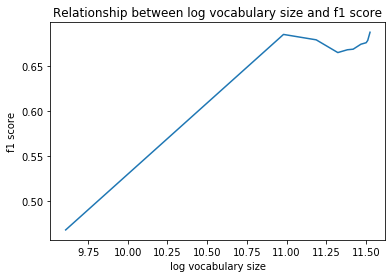

In [263]:
def P6():
    #Keep this random seed here to make comparison easier.
    np.random.seed(0)
    
    ## STUDENT START ###
    vocab = CountVectorizer() #create CountVectorizer object
    vocab_train = vocab.fit_transform(train_data) #fit and transform training data
    vocab_dev = vocab.transform(dev_data) #transform dev data
    
    score = [] #create empty lists to be used for plotting score vs size
    size = []
    
    for c in np.linspace(0.01, 1,10): #for different C values

        lreg_model = LogisticRegression(C=c, solver="liblinear", multi_class="auto", penalty="l1", tol=0.015) #create a model with C equal to c
        fitted_data = lreg_model.fit(vocab_train, train_labels) #fit training data
        
        weights = lreg_model.coef_.transpose() #get weights matrix and transpose in order to have n rows and 4 columns (corresponding to the 4 categories)
        weight_sums = np.sum(weights, axis=1)==0 #if there exists at least one non-zero weight in each row, the sum will be positive. we get a boolean numpy array by comparing all weight sums to 0
        vocab_reduced = [vocab.get_feature_names()[w] for w in range(len(weight_sums)) if weight_sums[w]==False] #for all nonzero weight sums, get the corresponding word feature by index and create a new vocabulary list
        
        vocab_r = CountVectorizer(vocabulary=vocab_reduced) #create a CountVectorizer object and specify our reduced vocabulary from above as our vocabulary
        vocab_train_r = vocab_r.fit_transform(train_data) #fit and transform training data
        vocab_dev_r = vocab_r.transform(dev_data) #transform dev data
        
        lreg_model_l2 = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto", penalty="l2", tol=0.015) #create logistic regression model with C=0.5
        fitted_data_l2 = lreg_model_l2.fit(vocab_train_r, train_labels) #fit reduced vocab fitted training data
        predicted_labels_l2 = lreg_model_l2.predict(vocab_dev_r) #predict on reduced vocab dev data
        f1 = metrics.f1_score(dev_labels, predicted_labels_l2, average='weighted') #get f1 score
        print("\Logistic regression model with L1 regularization strength", c)
        print("f1 score =",f1)
        score.append(f1) #append f1 score to scores array
        print("Vocabulary size =", vocab_train_r.size)
        size.append(vocab_train_r.size) #append size to sizes array
        print("\n-----------------------------------------------------------------")
        
        
    plt.plot(np.log(size), score) #plot log size vs. score
    plt.ylabel("f1 score")
    plt.xlabel("log vocabulary size")
    plt.title("Relationship between log vocabulary size and f1 score")
    ## STUDENT END ###

P6()

ANSWER: For smaller vocabulary sizes, larger vocabulary sizes correspond quite consistently with larger f1 scores. As we see, however f1 score peaks at close to e^11 and beyond that point does not improve but (inconsistently) seems to get worse.

### Part 7:

How is `TfidfVectorizer` different than `CountVectorizer`?

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

Show the 3 documents with highest R ratio, where ...<br/>
$R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$

Explain what the R ratio describes.  What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [264]:
def P7():
    ### STUDENT START ###
    vocab_tfid = TfidfVectorizer() #create TfidfVectorizer object
    vocab_tfid_train = vocab_tfid.fit_transform(train_data) #fit and transform training data
    vocab_tfid_dev = vocab_tfid.transform(dev_data) #transform dev data
    
    model = LogisticRegression(C=100, solver="liblinear", multi_class="auto") #produce logistic regression model with C=100
    fitted_data = model.fit(vocab_tfid_train, train_labels) #fit training data
    predicted_labels = model.predict(vocab_tfid_dev) #predict on dev data
    probabilities = model.predict_proba(vocab_tfid_dev) #get predicted probabilites for dev data
    
    def r_ratio(probabilities, top=3): #takes in predicted probabilities matrix and returns the indices of the features with the largest r ratios
    
        ratios = [] #create list of ratios

        for i in range(len(probabilities)): #for every row in predicted probability matrix
            maximum = max(probabilities[i]) #get the maximum predicted probability for the message
            correct = probabilities[i][dev_labels[i]] #get the predicted probability of the correct category of the message
            r_ratio = maximum/correct #divide the maximum predicted prob by correct predicted prob to get r ratio
            ratios.append((r_ratio,i)) #append tuple containing r ratio and row index to ratios list
        
        best = [sorted(ratios, reverse=True)[n][1] for n in range(top)] #sort ratios and get index of largest ones
        
        return best #return indices of highest ratios
    
    f1 = metrics.f1_score(dev_labels, predicted_labels, average='weighted') #get f1 score
    print(f1)
    ratios = r_ratio(probabilities) #get ratios corresponding to model's predicted probabilities

    for i in ratios: #print the messages corresponding to the highest r ratios
        print("\ntext",i)
        print("------------------------")
        print(dev_data[i])
        
    ### STUDENT END ###

P7()

0.7597662427853104

text 215
------------------------
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), but may not charge
anything for their time in making copies, or in any way realize a profit
from the use of this book. See the permissions noti

ANSWER: The TfidfVectorizer is different from CountVectorizer because instead of attaching weights according to frequency (as CV does), it attaches weights according to a word's proportional frequency with respect to all of the data.

What the R ratio essentially describes is the certainty with which the model is making a wrong classification. When a model is correctly classifying an example, its highest predicted probability will be the same as the predicted probability of the correct category, thereby yielding a ratio of 1. When the R ratio is higher than 1, however, it means that the model is attaching a higher probability to a category different from the correct one. The higher the proportional probability it is attaching to the wrong class, the higher the R ratio is going to be. Therefore, in a loose sense the R ratio is a measure of how mistakenly "confident" the model is. As we see in the examples above, a high R ratio is attached to ambiguous cases that contain words pertaining to more than one category (such as the first text that talks about getting "The Book of Mormon" (religion) in an electronic edition (computer graphics,possibly)). Nevertheless, we notice that other than the word "Mormon" (which admittedly is quite specific to the religion context) there are little to no other words suggesting the message belongs to the religion class. Therefore, a way to address this could be to get a measure of how many other context specific words are found in the same message so as to get an idea of how certain we can be about the classification.

### Part 8 EXTRA CREDIT:

Produce a Logistic Regression model to implement your suggestion from Part 7.